In [16]:
################### no use #######################
import sys
sys.path.append('..')
from Common.utils import read_data, ButterWorthFilter, numerical_grad_nd
import glob
import numpy as np
import torch
root = glob.glob('../data/trajectories/*')

def GetRoughData(path=root):
    ## Dataset preparation
    tau_list = []
    x_list = []
    for path in root:
        dataset = read_data(path)

        time = dataset[:,0]

        indx = max(np.where(time<38)[0])
        time = time[:indx]
        q_real = dataset[:indx,1:1+7]
        q_ref = dataset[:indx,8:8+7]
        qDot_real = dataset[:indx,15:15+7]
        u_cmd = dataset[:indx, 22:22+7]
        tau_real = dataset[:indx,29:29+7]
        Gra = dataset[:indx,36:36+7]
        u_G = u_cmd + Gra
        G_dat = dataset[:indx,36:36+7]
        C_dat = dataset[:indx, 43:43+7]
        M_dat = dataset[:indx, 50:50+49]

        qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)
        qDot_real_filtered, u_G_filtered = ButterWorthFilter(qDot_real, u_G, time)

        qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.
        
        ## have to calculate MCG torques by hand
        tau_MCG = []
        for i in range(len(tau_real)):
            tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
            tau_i += C_dat[i,:].reshape(7,1)
            tau_i += G_dat[i,:].reshape(7,1)
            tau_MCG.append(tau_i)
        tau_MCG = np.array(tau_MCG).reshape(len(tau_real), 7)
        x_i = np.concatenate([q_real, qDot_real, qDDot_inf], axis=1)
        x_list.append(x_i)
        tau_list.append(tau_real - tau_MCG)
    x = np.concatenate(x_list)
    tau = np.concatenate(tau_list)
    return x, tau

In [17]:
x, tau = GetRoughData()

In [18]:
x.shape

(220497, 21)

In [31]:
from regression import CV_RR
from sklearn.preprocessing import PolynomialFeatures

def feature1(x, FourierOrder=0):
    aug = x
    
    for k in range(1, FourierOrder):
        aug = np.concatenate([aug, np.sin(k*x)], axis=1)
        aug = np.concatenate([aug, np.cos(k*x)], axis=1)
    poly = PolynomialFeatures(1)
    aug = poly.fit_transform(aug)
    return aug

In [32]:
labd = np.logspace(3,7,10)
RR = CV_RR(labd)

### test set

In [21]:
path = '../data/test_trajectory/traj17_z.panda.dat'
x_list = []
tau_list = []
dataset = read_data(path)

time = dataset[:,0]

indx = max(np.where(time<38)[0])
time = time[:indx]
q_real = dataset[:indx,1:1+7]
q_ref = dataset[:indx,8:8+7]
qDot_real = dataset[:indx,15:15+7]
u_cmd = dataset[:indx, 22:22+7]
tau_real = dataset[:indx,29:29+7]
Gra = dataset[:indx,36:36+7]
u_G = u_cmd + Gra
G_dat = dataset[:indx,36:36+7]
C_dat = dataset[:indx, 43:43+7]
M_dat = dataset[:indx, 50:50+49]

qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)
qDot_real_filtered, u_G_filtered = ButterWorthFilter(qDot_real, u_G, time)

qDDot_inf = numerical_grad_nd(qDot_real_filtered) # numerical derivative to get joints acceleration.

## have to calculate MCG torques by hand
tau_MCG = []
for i in range(len(tau_real)):
    tau_i = M_dat[i,:].reshape(7,7) @ qDDot_inf[i, :].reshape(7,1)
    tau_i += C_dat[i,:].reshape(7,1)
    tau_i += G_dat[i,:].reshape(7,1)
    tau_MCG.append(tau_i)
tau_MCG = np.array(tau_MCG).reshape(len(tau_real), 7)
x_i = np.concatenate([q_real, qDot_real, qDDot_inf], axis=1)
x_list.append(x_i)
tau_list.append(tau_real - tau_MCG)
x_test = np.concatenate(x_list)
tau_test = np.concatenate(tau_list)

### plot the order of fourier order

In [7]:
ORDER = np.arange(1)
MAE_L = []
for order in ORDER:
    RR.fit(feature1(x, order), tau, 4, verbose=False)
    res_pred_RR = RR.predict(feature1(x_test, order), RR.beta)
    MAE = np.abs((tau_test - res_pred_RR)).sum() / len(tau_test)
    MAE_L.append(MAE)
    print("Mean absolute error [Order {0}]: {1:.3f}".format(order, MAE))

100%|██████████| 10/10 [00:00<00:00, 10.99it/s]

Mean absolute error [Order 0]: 3.305


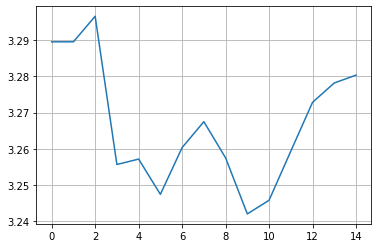

In [112]:
import matplotlib.pyplot as plt
plt.plot(ORDER, MAE_L)
plt.grid()
plt.show()

In [71]:
best_order = 8

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Min MSE:  1.8475351279487686


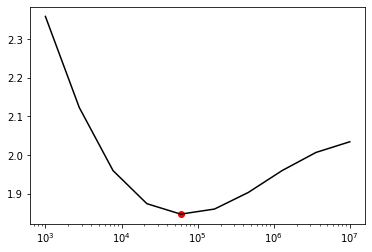

In [72]:
RR.fit(feature1(x, best_order+1), tau, 4)

In [73]:
res_pred_RR = RR.predict(feature1(x_test, best_order+1), RR.beta)

In [76]:
MAE = ((tau_test - res_pred_RR)**2).sum() / len(tau_test)
print("Mean square error [RR]: {:.2f}".format(MAE))

Mean square error [RR]: 3.38


In [77]:
MAE = (np.abs(tau_test[:,4] - res_pred_RR[:,4])).sum() / len(tau_test)
print("Mean square error [RR]: {:.3f}".format(MAE))

Mean square error [RR]: 0.283


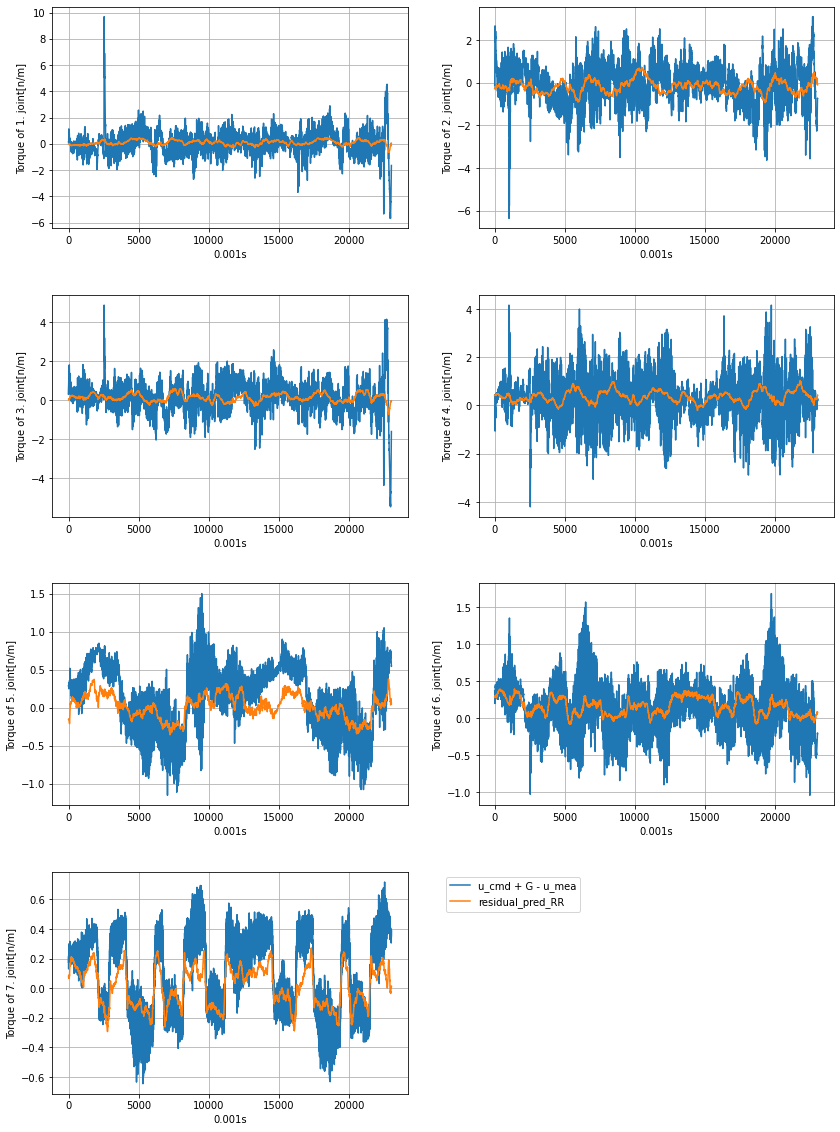

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=[14,20])
for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="0.001s", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.grid()
    plt.plot(tau_test[:,channel], label='u_cmd + G - u_mea')
    plt.plot(res_pred_RR[:,channel], label='residual_pred_RR')
#     plt.plot(res_pred_GP[:,channel], '-c', label='residual_pred_GP')
#     plt.plot(res_pred[:,channel] + var_pred, '-.r', linewidth=0.3, label='variance')
#     plt.plot(res_pred[:,channel] - var_pred, '-.r', linewidth=0.3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)    
plt.legend(bbox_to_anchor=(1.5, 1),fancybox=True)

plt.savefig('/home/jiayun/Desktop/residual.jpg', dpi=200)
plt.show()